In [1]:
from module_Plot import Plotting

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

import numpy as np
import pandas as pd
import os
import copy

plt.rcParams['axes.unicode_minus'] = False

In [2]:
loc = r'E:\data\_results\common_radar'
fn = 'TG_2D_Total_V06A.csv'
fn_csv = os.path.join(loc, fn)

dtypes = {'dlt_Dm':        np.float32,       
          'dlt_Tsec':      np.int32,         
          'rainType_TRMMKu':     np.float32,       
          'rainType_GPMKu':      np.float32,
          'LandOcean_GPMKu':     np.int32,       
          
#          'nearSurfRain_TRMMKu': np.float32,      
#          'nearSurfRain_GPMKu':  np.float32,    
          
          'dBZ20_Htop_TRMMKu':   np.float32,
          'dBZ20_Htop_GPMKu':   np.float32,
          'dBZ35_Htop_TRMMKu':   np.float32,
          'dBZ35_Htop_GPMKu':   np.float32,
          
          'nearSurfdBZ_TRMMKu':  np.float32,
          'nearSurfdBZ_GPMKu':   np.float32, 
          
          'Lon_GPMKu': np.float32, 
          'Lat_GPMKu': np.float32,
          
          'loc_x_TRMMKu': np.int32,
          'loc_y_TRMMKu': np.int32,  
          'orbitID_TRMMKu': np.int32,
          'loc_x_GPMKu': np.int32,
          'loc_y_GPMKu': np.int32,
          'orbitID_GPMKu': np.int32,
          }
xy_vars = ['dlt_Dm', 'dlt_Tsec']

fig_idxs = [f'({chr(ii)})' for ii in range(97, 123)]

In [5]:
xy_intl = [0.1, 1]  # [km, minute]
x_value, y_value = np.arange(xy_intl[0], 3+1.e-8, xy_intl[0]), np.arange(xy_intl[1], 20+1.e-8, xy_intl[1])
star_color = 'purple'

#########
def PCC_matrix(df_base, pcc_vars):
    PCC = np.full((x_value.size, y_value.size), fill_value=np.nan, dtype=np.float32)
    BIAS = np.full((x_value.size, y_value.size), fill_value=np.nan, dtype=np.float32)
    NUM = np.zeros((x_value.size, y_value.size), dtype=np.int32)
    for jdx, yval in enumerate(y_value):
        for idx, xval in enumerate(x_value):
            criteria = f'({xy_vars[0]} <= {xval:.1f}) & ({xy_vars[1]} <= {yval:.0f})'
#            print(criteria)
            df_tmp = df_base.query(criteria)
            
            NUM[idx, jdx] = df_tmp.shape[0]
            PCC[idx, jdx] = df_tmp[pcc_vars].corr().to_numpy()[0, 1]
            BIAS[idx, jdx] = (df_tmp[pcc_vars[1]] - df_tmp[pcc_vars[0]]).mean()
    
    return PCC, NUM, BIAS


def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"


def plot_grid(fn, grid_shade, grid_contour, shade_var='NUM', is_hist=True, hist_df=None, cb_label='PCC'):
    gcnt = np.zeros((x_value.size, y_value.size+1), dtype=np.float32)
    gcnt[:, :-1] = grid_contour.copy()
    gcnt[:, -1] = grid_contour[:, -1]
    
    plot = Plotting(global_xy=False, fontsize=14)
    cmap = plot.icmap.set_cmap(rng=list(np.arange(6)+1), c_firstwhite=False, kind='pr1') # copy.copy((cm.get_cmap('rainbow')))    

    sns.set_context('talk', font_scale=1)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    obj = ax.pcolormesh(np.array([0]+x_value.tolist()), np.array([0]+y_value.tolist()), grid_shade.T, cmap=cmap, shading='flat', 
                      #norm=colors.BoundaryNorm(boundaries=levs, ncolors=cmap.N), 
                      edgecolors='none', alpha=1, zorder=0)
    if shade_var == 'NUM':
        levs = np.arange(0.5, 0.95, 0.05)
        fmts, manual = None, None
    elif shade_var == 'PCC':
        levs = np.arange(50, 100, 10)
        fmts, manual = fmt, ((2.75, 18),(2.75, 16),(2.7, 12),(2.7, 8),(2.7, 6))
    else:
        levs = np.arange(50, 100, 10)
        fmts, manual = fmt, None
    CS = ax.contour(x_value-0.5*xy_intl[0], np.array((y_value-xy_intl[1]).tolist()+[y_value[-1]+xy_intl[1]]), gcnt.T, levels=levs, 
               linewidths=2, colors='k', alpha=1, zorder=1)
    ax.clabel(CS, inline=True, fontsize=14, fmt=fmts, manual=manual)
    
    ax.scatter(2.5-0.5*xy_intl[0], 15-0.5*xy_intl[1], marker="*", c=star_color, s=100)
    
    ax.set_xlim(0, x_value.max())   
    ax.set_ylim(0, y_value.max())   
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(xy_intl[0]))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(xy_intl[1]))
    
    if is_hist:
        ax_up = ax.inset_axes(bounds=[0, 1.06, 1, 0.3])
        sns.histplot(data=hist_df, x=xy_vars[0], bins=[0]+x_value.tolist(), kde=False, stat='percent', 
                     color='k', element='poly', fill=False, ax=ax_up, zorder=0)
        ax_up.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
        ax_up.xaxis.set_minor_locator(ticker.MultipleLocator(xy_intl[0]))
        ax_up.set_xticklabels([])
        ax_up.set_xlabel('')
        ax_up.set_ylabel('Percent (%)')
        ax_up.set_yticks([2, 4, 6])
        ax_up.vlines(2.5, ymin=0, ymax=ax_up.get_ylim()[-1], linestyle='--', color=star_color, zorder=2)
        ax_up.set_xlim(0, x_value.max()) 
        ax_up.set_ylim(0, ax_up.get_ylim()[-1]) 
        x2 = [2.5, 3] 
        ax_up.fill_between(x2, [ax_up.get_ylim()[-1]]*x2.__len__(), [0]*x2.__len__(), alpha=0.8, 
                         color='silver', edgecolor=None, zorder=1)
        
        ax_right = ax.inset_axes(bounds=[1.045, 0, 0.25, 1])
        sns.histplot(data=hist_df, y=xy_vars[1], bins=[0]+y_value.tolist(), kde=False, stat='percent', 
                     color='k', element='poly', fill=False, ax=ax_right, zorder=0)
        ax_right.yaxis.set_major_locator(ticker.MultipleLocator(5))
        ax_right.yaxis.set_minor_locator(ticker.MultipleLocator(xy_intl[1]))
        ax_right.set_yticklabels([])
        ax_right.set_ylabel('')
        ax_right.set_xlabel('Percent (%)')
        ax_right.set_xticks(np.arange(1, 13+1.e-8, 3))
        x2 = [0, ax_right.get_xlim()[-1]]
        ax_right.hlines(15, xmin=0, xmax=x2[-1], linestyle='--', color=star_color, zorder=2)
        ax_right.set_ylim(0, y_value.max())
        ax_right.set_xlim(0, x2[-1])
        ax_right.fill_between(x2, [15]*x2.__len__(), [20]*x2.__len__(), alpha=0.8, 
                         color='silver', edgecolor=None, zorder=1)
        
#        ax.text(1.05,1.15, s=fn.split('_')[1], fontsize=14, transform=ax.transAxes)
    #####
    if is_hist:
        cb_ax = ax.inset_axes(bounds=[0.05, -0.22, 0.9, 0.04])
        cb = fig.colorbar(obj, cb_ax, orientation='horizontal')
        cb_ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
        cb_ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    else:
        cb_ax = ax.inset_axes(bounds=[1.03, 0.05, 0.04, 0.9])
        cb = fig.colorbar(obj, cb_ax, orientation='vertical')
        cb_ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
        cb_ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    
    if shade_var == 'NUM':
        cb.set_ticks(np.arange(0, 100+1.e-8, 10))
#        cb.set_label(r'Samples ($\times$10$^4$)', labelpad=1)
        cb.set_label('Percentage of samples (%)', labelpad=1)
    elif shade_var == 'PCC':
        cb.set_ticks(np.arange(0.5, 1+1.e-8, 0.02))
        cb.set_label(cb_label, labelpad=1)
    else: 
        cb.set_label(cb_label, labelpad=1)

    cb.ax.tick_params(direction='in', length=6)
    cb.ax.tick_params(which='minor', direction='in', length=4)    
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time interval (minute)')
    
    plot._save_fig(fn, fig)
    del plot
    return

In [6]:
df = pd.read_csv(fn_csv, usecols=dtypes.keys(), dtype=dtypes, compression='gzip')
df.loc[:, 'dlt_Dm'] = df['dlt_Dm']/1000     # [m --> km]
df.loc[:, 'dlt_Tsec'] = df['dlt_Tsec']/60   # [second --> minute]

df.describe()

,loc_x_TRMMKu,loc_y_TRMMKu,Lon_GPMKu,Lat_GPMKu,loc_x_GPMKu,loc_y_GPMKu,dlt_Dm,dlt_Tsec,orbitID_TRMMKu,nearSurfdBZ_TRMMKu,rainType_TRMMKu,orbitID_GPMKu,nearSurfdBZ_GPMKu,LandOcean_GPMKu,rainType_GPMKu,dBZ20_Htop_TRMMKu,dBZ35_Htop_TRMMKu,dBZ20_Htop_GPMKu,dBZ35_Htop_GPMKu
count,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06,193141.000000,215763.000000,5.555204e+06,262369.000000,5.555204e+06,292955.000000,5.555204e+06,5.555204e+06,5.555204e+06,5.555204e+06
mean,4.606090e+03,2.401950e+01,-4.519809e-01,2.950151e+00,3.664194e+03,2.401104e+01,1.750772e+00,8.325637e+00,9.410472e+04,27.899212,1.450721,1.338017e+03,25.297689,2.780692e-01,1.535823,2.111010e-01,3.616137e-02,2.453773e-01,3.920700e-02
std,2.325003e+03,1.429825e+01,1.033098e+02,1.746541e+01,1.936857e+03,1.414337e+01,6.546466e-01,5.705163e+00,9.295147e+02,6.537040,0.558648,9.276533e+02,7.709689,4.801016e-01,0.655669,1.136892e+00,4.139320e-01,1.223366e+00,4.330940e-01
min,4.100000e+01,0.000000e+00,-1.799999e+02,-3.522978e+01,6.700000e+01,0.000000e+00,2.024267e-03,0.000000e+00,9.292600e+04,17.769791,1.000000,1.610000e+02,0.763357,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.341000e+03,1.200000e+01,-8.896939e+01,-1.146972e+01,1.833000e+03,1.200000e+01,1.282344e+00,3.550000e+00,9.323200e+04,22.391607,1.000000,4.670000e+02,18.841253,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.560000e+03,2.400000e+01,-1.818529e+00,5.645487e+00,2.527000e+03,2.400000e+01,1.813365e+00,7.000000e+00,9.393700e+04,26.898516,1.000000,1.171000e+03,24.223862,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.559000e+03,3.700000e+01,8.827869e+01,1.694149e+01,5.633000e+03,3.600000e+01,2.258426e+00,1.303333e+01,9.483600e+04,32.165344,2.000000,2.068000e+03,30.588100,1.000000e+00,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,8.896000e+03,4.800000e+01,1.800000e+02,3.592128e+01,6.660000e+03,4.800000e+01,2.999999e+00,2.000000e+01,9.623000e+04,62.944580,3.000000,3.459000e+03,60.804680,3.000000e+00,3.000000,2.188170e+01,1.976495e+01,2.181748e+01,2.047254e+01


In [7]:
# filter: dBZ20_Htop
thh_dBZ_GPM, thh_dBZ_TRMM = 18, 18  # dBZ
key_vars = ['dBZ20_Htop_TRMMKu', 'dBZ20_Htop_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & (nearSurfdBZ_TRMMKu>={thh_dBZ_TRMM}) & (nearSurfdBZ_GPMKu>={thh_dBZ_GPM})'
#filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & (LandOcean_GPMKu == 0) & (rainType_TRMMKu == 2) & (rainType_GPMKu == 2)' # Conv. both over land  
#filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & (LandOcean_GPMKu == 0) & (rainType_TRMMKu == 1) & (rainType_GPMKu == 1)' # Stra. both over land  

Topht20 = df.query(filter)  #[xy_vars + key_vars]
print(Topht20.describe())
      
##############
PCC_Topht20, NUM_Topht20, BIAS_Topht20 = PCC_matrix(Topht20, key_vars)
'''
fn = 'PCC_Topht20_2014coincident_01A'
plot_grid(fn, 100*NUM_Topht20/NUM_Topht20.max(), PCC_Topht20, shade_var='NUM', is_hist=False, hist_df=Topht20)
fn = 'PCC_Topht20_2014coincident_01B'
plot_grid(fn, 100*NUM_Topht20/NUM_Topht20.max(), PCC_Topht20, shade_var='NUM', is_hist=True, hist_df=Topht20)

'''
fn = 'PCC_Topht20_2014coincident_02A'
plot_grid(fn, PCC_Topht20, 100*NUM_Topht20/NUM_Topht20.max(), shade_var='PCC', is_hist=False, hist_df=Topht20)
fn = 'PCC_Topht20_2014coincident_02B'
plot_grid(fn, PCC_Topht20, 100*NUM_Topht20/NUM_Topht20.max(), shade_var='PCC', is_hist=True, hist_df=Topht20)

'''
BIAS_Topht20[NUM_Topht20<=400] = np.nan

fn = 'BIAS_ConvOcean_Topht20_2014coincident_02A'
plot_grid(fn, BIAS_Topht20, 100*NUM_Topht20/np.nanmax(NUM_Topht20), shade_var='BIAS', is_hist=False, hist_df=Topht20, cb_label='BIAS (km)')
#fn = 'BIAS_Stra_Topht20_2014coincident_02B'
#plot_grid(fn, BIAS_Topht20, 100*NUM_Topht20/np.nanmax(NUM_Topht20), shade_var='BIAS', is_hist=True, hist_df=Topht20, cb_label='BIAS (km)')
'''

        loc_x_TRMMKu   loc_y_TRMMKu      Lon_GPMKu      Lat_GPMKu  \
count  140697.000000  140697.000000  140697.000000  140697.000000   
mean     4789.623105      24.524418      10.466575       2.457448   
std      2301.223826      14.020504     112.041603      14.925465   
min        60.000000       0.000000    -179.998276     -34.932213   
25%      2454.000000      13.000000     -84.849602      -7.835015   
50%      5915.000000      25.000000       9.919799       4.474290   
75%      6709.000000      37.000000     114.922195      11.988668   
max      8888.000000      48.000000     179.999557      35.756569   

         loc_x_GPMKu    loc_y_GPMKu         dlt_Dm       dlt_Tsec  \
count  140697.000000  140697.000000  140697.000000  140697.000000   
mean     4091.433748      24.776626       1.738078       7.989083   
std      1943.483431      14.285091       0.656990       6.010588   
min       428.000000       0.000000       0.006534       0.000000   
25%      2055.000000      12.0000

"\nBIAS_Topht20[NUM_Topht20<=400] = np.nan\n\nfn = 'BIAS_ConvOcean_Topht20_2014coincident_02A'\nplot_grid(fn, BIAS_Topht20, 100*NUM_Topht20/np.nanmax(NUM_Topht20), shade_var='BIAS', is_hist=False, hist_df=Topht20, cb_label='BIAS (km)')\n#fn = 'BIAS_Stra_Topht20_2014coincident_02B'\n#plot_grid(fn, BIAS_Topht20, 100*NUM_Topht20/np.nanmax(NUM_Topht20), shade_var='BIAS', is_hist=True, hist_df=Topht20, cb_label='BIAS (km)')\n"

In [8]:
# answer reviewer02, PCC color
sfx_cols = ['rainType_TRMMKu', 'rainType_GPMKu', 'LandOcean_GPMKu',       
            'loc_x_TRMMKu', 'loc_y_TRMMKu', 'orbitID_TRMMKu', 'loc_x_GPMKu', 'loc_y_GPMKu', 'orbitID_GPMKu']

PCC = np.full(5, fill_value=np.nan, dtype=np.float32)
NUM = np.zeros(5, dtype=np.int32)
SMPs = {}

yval = 4
for idx, xval in enumerate(x_value[:4]):
    criteria = f'({xy_vars[0]} <= {xval:.1f}) & ({xy_vars[1]} <= {yval:.0f})'
    df_tmp = Topht20.query(criteria)[key_vars+[xy_vars[0]]+sfx_cols]

    NUM[idx] = df_tmp.shape[0]
    PCC[idx] = df_tmp[key_vars].corr().to_numpy()[0, 1]
    SMPs[idx] = df_tmp[key_vars+sfx_cols]
    SMPs[idx]['AbsDlt_Topht20'] = np.abs((df_tmp[key_vars[1]] - df_tmp[key_vars[0]]).values)
    SMPs[idx]['New'] = 0
    if idx > 0:
        SMPs[idx].loc[df_tmp[xy_vars[0]]>x_value[idx-1], 'New'] = 1
    SMPs[idx].columns = ['TRMM_PR', 'GPM_KuPR']+sfx_cols+['AbsDlt_Topht20','New']
#    print(df_tmp[key_vars].max(), df_tmp[key_vars].min())
    
rngs = [0.5, 17.5]

In [7]:
tmps = SMPs[1].query('(New==1)&(AbsDlt_Topht20>2)')
tmps.describe()

,TRMM_PR,GPM_KuPR,rainType_TRMMKu,rainType_GPMKu,LandOcean_GPMKu,loc_x_TRMMKu,loc_y_TRMMKu,orbitID_TRMMKu,loc_x_GPMKu,loc_y_GPMKu,orbitID_GPMKu,AbsDlt_Topht20,New
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0
mean,7.674458,8.840300,1.521739,1.608696,0.304348,5699.869565,20.391304,93364.956522,4874.260870,27.043478,599.565217,3.592206,1.0
std,3.451610,3.571409,0.510754,0.499011,0.558796,2047.876490,15.314103,649.006757,1681.229102,13.946255,647.639337,1.649570,0.0
min,2.121250,1.911017,1.000000,1.000000,0.000000,2093.000000,2.000000,93121.000000,1842.000000,0.000000,356.000000,2.080893,1.0
25%,5.930788,6.840633,1.000000,1.000000,0.000000,4357.500000,10.000000,93152.000000,4134.500000,19.000000,387.000000,2.345518,1.0
50%,6.724359,8.901680,2.000000,2.000000,0.000000,6699.000000,15.000000,93189.000000,5683.000000,33.000000,424.000000,3.063328,1.0
75%,10.785608,10.664397,2.000000,2.000000,0.500000,7102.000000,33.000000,93208.500000,6005.500000,37.000000,443.500000,4.179421,1.0
max,13.277344,15.783871,2.000000,2.000000,2.000000,7334.000000,48.000000,95901.000000,6190.000000,46.000000,3130.000000,8.216592,1.0


In [16]:
Ddlt = 3
for idx, idf in SMPs.items():
    nn = idf.query(f'(New==1)&(AbsDlt_Topht20>{Ddlt})').shape[0]
    nn_all = idf.query(f'(AbsDlt_Topht20>{Ddlt})').shape[0]
    print(idx, nn, nn_all, 100*nn_all/idf.shape[0])

0 0 0 0.0
1 12 12 3.6809815950920246
2 11 23 2.9449423815621
3 13 36 2.55500354861604


In [8]:
def plot_multi_scatters(fn, dadfs, PCCs, NUMs):
    plot = Plotting(global_xy=False, fontsize=22)
    
    nrows, ncols = 1, 4
    sns.set_context('talk', font_scale=1)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4),sharey=True) # sharex=True, 
    fig.subplots_adjust(wspace=0.15, hspace=0.15)
    
    for idx in np.arange(ncols):
        iax = ax[idx]
        
        if idx == 1:
            is_lgd = True
        else:
            is_lgd = False
        
        dadf = dadfs[idx].query('New==0')[['GPM_KuPR', 'TRMM_PR']]
        iax.scatter(x=dadf['GPM_KuPR'], y=dadf['TRMM_PR'],
                        s=30, color='blue',  #hue='New', style='New', 
                        label='Old',# legend=is_lgd,
                        marker='.', edgecolor=None, alpha=0.4)
        
        dadf = dadfs[idx].query('New==1')[['GPM_KuPR', 'TRMM_PR']]
        iax.scatter(x=dadf['GPM_KuPR'], y=dadf['TRMM_PR'],
                        s=30, color='red',  #hue='New', style='New'
                        label='New',#  legend=is_lgd,
                        marker='.', edgecolor=None, alpha=0.4)
        
        if is_lgd:
            hand, _ = iax.get_legend_handles_labels()
            iax.legend(hand, ['Old','New'], fontsize=14,
                       loc=(-0.52,0.02), ncol=1)
        
        iax.set_xlim(rngs)
        iax.set_ylim(rngs)
        
        iax.xaxis.set_major_locator(ticker.MultipleLocator(4))
        iax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        iax.yaxis.set_major_locator(ticker.MultipleLocator(4))
        iax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
        iax.axline(xy1=(rngs[0], rngs[0]), xy2=(rngs[1], rngs[1]), linestyle='--', color='k')
        
        if (idx==0):
            iax.set_ylabel('TRMM_PR')
        if idx ==2:
            iax.set_xlabel('')
            iax.text(x=-0.275, y=-0.15, s='GPM_KuPR', 
                 ma='left', ha='left', va='top', color='black', transform=iax.transAxes)
        else:
            iax.set_xlabel('')
        
        iax.text(x=0.01, y=0.98, s=f'{fig_idxs[idx]}', 
                 ma='left', ha='left', va='top', color='black', transform=iax.transAxes)
        iax.text(x=0, y=1.01, 
                     s=f'PCC={PCCs[idx]:5.03f}    NUM={NUMs[idx]:4.0f}',  
                     ma='left', ha='left', va='bottom', color='black', transform=iax.transAxes)
        
    plot._save_fig(fn, fig)  
    del plot
    return

In [9]:
# END answer reviewer02
fn = 'coincident_scatter5_PCC'
plot_multi_scatters(fn, SMPs, PCC, NUM)

In [53]:
Topht20.columns

Index(['Lon_GPMKu', 'Lat_GPMKu', 'dlt_Dm', 'dlt_Tsec', 'nearSurfdBZ_TRMMKu',
       'rainType_TRMMKu', 'nearSurfdBZ_GPMKu', 'LandOcean_GPMKu',
       'rainType_GPMKu', 'dBZ20_Htop_TRMMKu', 'dBZ35_Htop_TRMMKu',
       'dBZ20_Htop_GPMKu', 'dBZ35_Htop_GPMKu'],
      dtype='object')

In [61]:
#import matplotlib.pyplot as plt
#from matplotlib import cm, colors, ticker
#import seaborn as sns
import cartopy.crs as ccrs
import copy

import vaex as ve


levs0 = [1, 10, 50, 100] +list(np.arange(500, 4500, 500))
levs1 = [1, 10, 50] +list(np.arange(100, 1100, 100))

lon_center = 0

grid_resolution = 2
grid_x, grid_y = np.meshgrid(np.arange(-179, 180, grid_resolution), np.arange(-37, 38, grid_resolution))
grid_x, grid_y = grid_x.T, grid_y.T

glb_lims, glb_shp = [[-180, 180.00000001], [-38,38.00000001]], [180, 38]

##################
def plot_CPs_multi(name, datas, unit='',save_zero=True, ll_rng=[], 
              cmap_rng=[], extend='neither', ckind='pr', pic_subdir=''):
    
    plot = Plotting(global_xy=True, fontsize=14,
                    cb_shrink=0.9, cb_orientation='vertical')
    
    cmap = plot.icmap.set_cmap(rng=cmap_rng, c_firstwhite=False, kind=ckind) 
    
    sns.set_context('talk', font_scale=1.0)  #         
    proj = ccrs.PlateCarree(central_longitude=lon_center)  # np.mean(lon_rng)
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 6), #sharex=True,
                           subplot_kw=dict(projection=proj))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    ####
    ii = 0
    obj0 = ax[ii].contourf(grid_x, grid_y, datas[0]+1.e-8, 
                          cmap=cmap, levels=levs0, 
                          norm=colors.BoundaryNorm(boundaries=np.array(levs0), ncolors=cmap.N), 
                          alpha=1, zorder=2, extend='max')
    obj0.cmap.set_over('indigo')
    _, cb = plot.__load_ax_settings__(fig, ax[ii], proj, obj0, var='', rng=ll_rng, unit=unit, lon_center=lon_center,
                             pad=0.02, aspect=15)
    
    cb.ax.set_yticks(cb.ax.get_yticks())
    tlabs = [val.get_text() for val in cb.ax.get_yticklabels()]
    cb.ax.set_yticklabels([val if int(val)<1000 else f'{int(val)/1000:.0f},000' for val in tlabs])
    
    ax[ii].text(x=0.01, y=1.01, s=f'{fig_idxs[ii]}', 
                 ma='right', ha='left', va='bottom', color='black', transform=ax[ii].transAxes) #fontsize=12, 
    
    ####
    ii = 1
    obj1 = ax[ii].contourf(grid_x, grid_y, datas[1]+1.e-8,  
                          cmap=cmap, levels=levs1, 
                          norm=colors.BoundaryNorm(boundaries=np.array(levs1), ncolors=cmap.N), 
                          alpha=1, zorder=2, extend='max')
    obj1.cmap.set_over('indigo')
    _, cb = plot.__load_ax_settings__(fig, ax[ii], proj, obj1, var='', rng=ll_rng, unit=unit, lon_center=lon_center,
                             pad=0.02, aspect=15)
    cb.ax.set_yticks(cb.ax.get_yticks())
    tlabs = [val.get_text() for val in cb.ax.get_yticklabels()]
    cb.ax.set_yticklabels([val if int(val)<1000 else f'{int(val)/1000:.0f},000' for val in tlabs])
    
    ax[ii].text(x=0.01, y=1.01, s=f'{fig_idxs[ii]}', 
                 ma='right', ha='left', va='bottom', color='black', transform=ax[ii].transAxes) #fontsize=12, 
    
    
    plot._save_fig(name, fig)
    del plot
    
    
def grid_counts(VEDF, COLS, selection=[]):
    if len(selection) == 0:
        data = VEDF.count(VEDF[COLS[-1]], binby=COLS[:2], limits=glb_lims, shape=glb_shp
                              ).astype(np.int32)
    else:
        sele = ' & '.join(selection) if selection.__len__() > 1 else selection[0]
        data = VEDF.count(VEDF[COLS[-1]], binby=COLS[:2], limits=glb_lims, shape=glb_shp,
                              selection=sele).astype(np.int32)
            
    return data

In [9]:
DT_filter = f'({xy_vars[0]} <= 2.5) & ({xy_vars[1]} <= 15)'
vedf_all = ve.from_pandas(df.query(DT_filter))
vedf_CPs = ve.from_pandas(Topht20.query(DT_filter))
print(vedf_all.shape, vedf_CPs.shape)

cols = ['Lon_GPMKu', 'Lat_GPMKu', 'dlt_Tsec']
grid_all = grid_counts(vedf_all[cols], cols)
grid_CPs = grid_counts(vedf_CPs[cols], cols)
print(grid_all.max(), grid_CPs.max())

(3929231, 19) (97619, 19)
4102 1015


In [62]:
name = 'Global_distribution_multi_CPs'
tmp = plot_CPs_multi(name, [grid_all, grid_CPs], ll_rng=[-180, 180, -38, 38],
               cmap_rng=list(np.arange(6)+1), ckind='pr1',extend='max')

<ipython-input-61-8ba86e8737cc>:45: UserWarning: Use the colorbar set_ticks() method instead.
  cb.ax.set_yticks(cb.ax.get_yticks())
<ipython-input-61-8ba86e8737cc>:61: UserWarning: Use the colorbar set_ticks() method instead.
  cb.ax.set_yticks(cb.ax.get_yticks())


In [12]:
# filter: nearSurfdBZ
key_vars = ['nearSurfdBZ_TRMMKu', 'nearSurfdBZ_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0)'
nearSurfdBZ = df.query(filter)[xy_vars + key_vars]
print(nearSurfdBZ.describe())

##############
PCC_nearSurfdBZ, NUM_nearSurfdBZ, _ = PCC_matrix(nearSurfdBZ, key_vars)
'''
fn = 'PCC_nearSurfdBZ_2014coincident_01A'
plot_grid(fn, 100*NUM_nearSurfdBZ/NUM_nearSurfdBZ.max(), PCC_nearSurfdBZ, shade_var='NUM', is_hist=False, hist_df=nearSurfdBZ)
fn = 'PCC_nearSurfdBZ_2014coincident_01B'
plot_grid(fn, 100*NUM_nearSurfdBZ/NUM_nearSurfdBZ.max(), PCC_nearSurfdBZ, shade_var='NUM', is_hist=True, hist_df=nearSurfdBZ)
'''

fn = 'PCC_nearSurfdBZ_2014coincident_02A'
plot_grid(fn, PCC_nearSurfdBZ, 100*NUM_nearSurfdBZ/NUM_nearSurfdBZ.max(), shade_var='PCC', is_hist=False, hist_df=nearSurfdBZ)
fn = 'PCC_nearSurfdBZ_2014coincident_02B'
plot_grid(fn, PCC_nearSurfdBZ, 100*NUM_nearSurfdBZ/NUM_nearSurfdBZ.max(), shade_var='PCC', is_hist=True, hist_df=nearSurfdBZ)

              dlt_Dm       dlt_Tsec  nearSurfdBZ_TRMMKu  nearSurfdBZ_GPMKu
count  160527.000000  160527.000000       160527.000000      160527.000000
mean        1.740163       8.057297           28.494213          27.848175
std         0.656345       6.021128            6.689068           7.723290
min         0.006534       0.000000           18.277407           0.763357
25%         1.271936       2.683333           22.856597          21.869166
50%         1.804850       6.250000           27.665642          27.475376
75%         2.245487      13.516667           32.986403          33.250204
max         2.999968      20.000000           62.944580          60.804680


In [138]:
# filter: nearSurfRain
key_vars = ['nearSurfRain_TRMMKu', 'nearSurfRain_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0)'
nearSurfRain = df.query(filter)[xy_vars + key_vars]
print(nearSurfRain.describe())
      
##############
PCC_nearSurfRain, NUM_nearSurfRain, _ = PCC_matrix(nearSurfRain, key_vars)

fn = 'PCC_nearSurfRain_2014coincident_01A'
plot_grid(fn, 100*NUM_nearSurfRain/NUM_nearSurfRain.max(), PCC_nearSurfRain, shade_var='NUM', is_hist=False, hist_df=nearSurfRain)
fn = 'PCC_nearSurfRain_2014coincident_01B'
plot_grid(fn, 100*NUM_nearSurfRain/NUM_nearSurfRain.max(), PCC_nearSurfRain, shade_var='NUM', is_hist=True, hist_df=nearSurfRain)

fn = 'PCC_nearSurfRain_2014coincident_02A'
plot_grid(fn, PCC_nearSurfRain, 100*NUM_nearSurfRain/NUM_nearSurfRain.max(), shade_var='PCC', is_hist=False, hist_df=nearSurfRain)
fn = 'PCC_nearSurfRain_2014coincident_02B'
plot_grid(fn, PCC_nearSurfRain, 100*NUM_nearSurfRain/NUM_nearSurfRain.max(), shade_var='PCC', is_hist=True, hist_df=nearSurfRain)

              dlt_Dm       dlt_Tsec  nearSurfRain_TRMMKu  nearSurfRain_GPMKu
count  160527.000000  160527.000000        160527.000000       160527.000000
mean        1.740163       8.057297             3.602642            3.611163
std         0.656345       6.021128             8.454342           10.590483
min         0.006534       0.000000             0.192197            0.010640
25%         1.271936       2.683333             0.717772            0.598604
50%         1.804850       6.250000             1.506336            1.365430
75%         2.245487      13.516667             3.251962            3.229117
max         2.999968      20.000000           299.835419          299.997803


            dlt_Dm     dlt_Tsec  dBZ20_Htop_TRMMKu  dBZ20_Htop_GPMKu
count  8799.000000  8799.000000        8799.000000       8799.000000
mean      1.758698     8.362729           5.984379          5.834938
std       0.658488     6.215164           1.802097          2.531938
min       0.019905     0.000000           1.427326          0.673410
25%       1.292965     2.666667           4.735621          3.796410
50%       1.832147     6.350000           5.556569          5.793382
75%       2.267339    14.583333           6.922196          7.518085
max       2.998468    20.000000          16.049715         16.986034


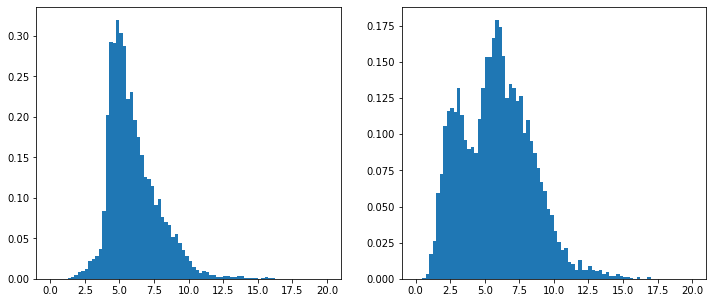

In [7]:
%matplotlib inline

key_vars = ['dBZ20_Htop_TRMMKu', 'dBZ20_Htop_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & (rainType_TRMMKu == 1) & (rainType_GPMKu == 2) & (LandOcean_GPMKu == 0)'
Topht20 = df.query(filter)[xy_vars + key_vars]
print(Topht20.describe())

Dist_bins = np.arange(0, 3.01, 0.1)
Time_bins = np.arange(0, 21, 1)
hgt_bins = np.arange(0, 20.01, 0.25)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
#ax[0].hist(Topht20[xy_vars[0]], bins=Dist_bins, density=True)
#ax[1].hist(Topht20[xy_vars[1]], bins=Time_bins, density=True)
ax[0].hist(Topht20[key_vars[0]], bins=hgt_bins, density=True)
ax[1].hist(Topht20[key_vars[1]], bins=hgt_bins, density=True)
plt.show()

             dlt_Dm      dlt_Tsec  dBZ20_Htop_TRMMKu  dBZ20_Htop_GPMKu
count  14349.000000  14349.000000       14349.000000      14349.000000
mean       1.740515      8.258677           4.683732          5.309959
std        0.655640      6.197356           2.299115          1.943914
min        0.019558      0.000000           0.849265          0.911638
25%        1.270751      2.633333           2.996245          4.015816
50%        1.797851      6.383333           3.882445          4.940266
75%        2.248399     14.300000           6.074219          6.278572
max        2.999925     20.000000          16.141932         16.363197


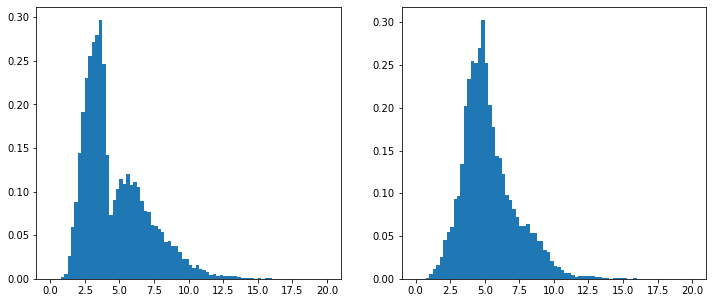

In [8]:
%matplotlib inline

key_vars = ['dBZ20_Htop_TRMMKu', 'dBZ20_Htop_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & (rainType_TRMMKu == 2) & (rainType_GPMKu == 1) & (LandOcean_GPMKu == 0)'
Topht20 = df.query(filter)[xy_vars + key_vars]
print(Topht20.describe())

Dist_bins = np.arange(0, 3.01, 0.1)
Time_bins = np.arange(0, 21, 1)
hgt_bins = np.arange(0, 20.01, 0.25)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
#ax[0].hist(Topht20[xy_vars[0]], bins=Dist_bins, density=True)
#ax[1].hist(Topht20[xy_vars[1]], bins=Time_bins, density=True)
ax[0].hist(Topht20[key_vars[0]], bins=hgt_bins, density=True)
ax[1].hist(Topht20[key_vars[1]], bins=hgt_bins, density=True)
plt.show()

              dlt_Dm       dlt_Tsec  dBZ20_Htop_TRMMKu  dBZ20_Htop_GPMKu
count  134027.000000  134027.000000      134027.000000     134027.000000
mean        1.735807       7.888415           5.919035          6.027219
std         0.657031       6.008118           2.188769          2.328456
min         0.006534       0.000000           0.625000          0.250000
25%         1.266300       2.633333           4.742872          4.739451
50%         1.800100       6.000000           5.666295          5.813725
75%         2.242028      13.116667           7.215242          7.455626
max         2.999968      20.000000          18.522261         20.069527


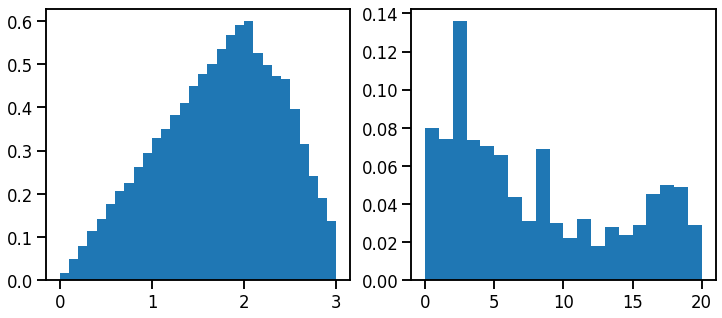

In [34]:
%matplotlib inline

key_vars = ['dBZ20_Htop_TRMMKu', 'dBZ20_Htop_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & (rainType_TRMMKu == rainType_GPMKu)'
Topht20 = df.query(filter)[xy_vars + key_vars]
print(Topht20.describe())

Dist_bins = np.arange(0, 3.01, 0.1)
Time_bins = np.arange(0, 21, 1)

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].hist(Topht20[xy_vars[0]], bins=Dist_bins, density=True)
ax[1].hist(Topht20[xy_vars[1]], bins=Time_bins, density=True)
plt.show()

In [14]:
key_vars = ['dBZ20_Htop_TRMMKu', 'dBZ20_Htop_GPMKu', 'rainType_TRMMKu', 'rainType_GPMKu']
filter = f'({key_vars[0]} > 0) & ({key_vars[1]} > 0) & ({xy_vars[0]}<=2.5) & ({xy_vars[1]}<=15) & (LandOcean_GPMKu == 1)'
Topht20 = df.query(filter)[xy_vars + key_vars]

total = Topht20.shape[0]
for ii in [2, 1, 3]:
    for jj in [2, 1, 3]:
        filter = f'(rainType_TRMMKu=={ii}) & (rainType_GPMKu == {jj})' 
        num = Topht20.query(filter).shape[0]
        print(ii, jj, num, 100*num/total)

2 2 5761 18.343628605998855
2 1 3331 10.606253582118066
2 3 80 0.25472839584792717
1 2 2573 8.192702031458957
1 1 17203 54.776157422148636
1 3 906 2.884799082977775
3 2 79 0.25154429089982805
3 1 523 1.6652868878558238
3 3 950 3.0248997006941347


In [8]:
df.shape

(5555204, 11)